## Assignment 3 - Working with RNNs


This jupyter notebook contains my code for a character-level Recurrent Neural Network. The network was trained on first book in the series *Song of Ice and Fire*.

In [556]:
# imports
%matplotlib notebook

import numpy as np
import torch as t
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

### Part 1 - Data loading and Preprocessing

In [557]:
data = open('./data/input.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), 256
print ('data has %d characters, %d unique' % (data_size, 
                                             vocab_size))
notWanted = ['!', '*', '~', ';', "'", '-', '\n', '`', ']', '[', '(', ')', ':', '"', '0', '1', '2', '3', 
             '4', '5', '6', '7', '8', '9']
new_data = ""
for i in data:
    if(i not in notWanted):
        new_data+=i
chars = list(set(new_data))

data has 1607794 characters, 256 unique


In [558]:
data = new_data[0:1015]
print(data)

We should start back, Gared urged as the woods began to grow dark around them. The wildlings are dead. Do the dead frighten you? Ser Waymar Royce asked with just the hint of a smile. Gared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. Dead is dead, he said. We have no business with the dead. Are they dead? Royce asked softly. What proof have we? Will saw them, Gared said. If he says they are dead, thats proof enough for me. Will had known they would drag him into the quarrel sooner or later. He wished it had been later rather than sooner. My mother told me that dead men sing no songs, he put in. My wet nurse said the same thing, Will, Royce replied. Never believe anything you hear at a womans tit. There are things to be learned even from the dead. His voice echoed, too loud in the twilit forest. Page We have a long ride before us, Gared pointed out. Eight days, maybe nine. And night is falling. Ser Waymar Royce glanced at the sky wi

In [593]:
# hyperparameters
class RNN():
    def __init__(self, num_neurons, seq_length):
        # model parameters
        self.Wxh = t.rand(num_neurons, vocab_size).cuda()*0.01 # input to hidden
        self.Whh = t.rand(num_neurons, num_neurons).cuda()*0.01 # hidden to hidden
        self.Why = t.rand(vocab_size, num_neurons).cuda()*0.01 # hidden to output
        self.Hbias = t.zeros((num_neurons, 1)).cuda() # hidden bias
        self.Ybias = t.zeros((vocab_size, 1)).cuda() # output bias
        self.hiddenS = num_neurons
        self.length = seq_length
    
    def forward(self, inputs, hprev):
        """
        inputs, targets are matrices of size N * 256,
        where N is sequence length used.
        """
        
        hs = t.zeros((self.length+1, self.hiddenS)).cuda()
        os = t.zeros(( self.length, vocab_size)).cuda()
        hs[0, :] = hprev.contiguous().view(1,-1)
        for i in range(1, self.length+1):
            hs[i] = F.tanh(t.mm(self.Wxh, inputs[i-1].contiguous().view(-1,1)).cuda() + 
                              t.mm(self.Whh, hs[i-1].contiguous().view(-1, 1)).cuda() + self.Hbias)
            temp = t.mm(self.Why, hs[i].contiguous().view(-1,1)).cuda() + self.Ybias
            os[i-1] = t.exp(temp).cuda() / t.sum(t.exp(temp).cuda())
        
        hprev = hs[self.length]
        return (hs, os, hprev)
    
    def bptt(self, hs, os, inputs, targets):
        dWhy, dWhh, dWxh = t.zeros_like(self.Why), t.zeros_like(self.Whh), t.zeros_like(self.Wxh)
        dbh, dby = t.zeros_like(self.Hbias), t.zeros_like(self.Ybias) # memory variable for adagrad
        dhnext = t.zeros(self.hiddenS,1).cuda()
        for i in range(self.length, 0, -1):
            dy = (os[i-1] - targets[i-1]).contiguous().view(-1,1).cuda()
            dWhy += t.mm(dy, hs[i].contiguous().view(1,-1)).cuda()
            
            dby += dy # output bias update
            dh = t.mm(t.t(self.Why), dy).cuda() + dhnext # backprop into hidden layer
            g = (1-hs[i]*hs[i]).contiguous().view(-1,1)
            dh1 = g * dh # backprop with tanh non-linearity

            dbh += dh1 # hidden state bias update
            
            dWxh += t.mm(dh1, inputs[i-1].contiguous().view(1, -1)).cuda()
            dWhh += t.mm(dh1, hs[i-1].contiguous().view(1, -1)).cuda()
            dhnext = t.mm(t.t(self.Whh).cuda(), dh1)
            
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            t.clamp(dparam, -5, 5, out=dparam)
        return dWxh, dWhh, dWhy, dbh, dby

In [594]:
def crossEnloss(seq_length, targets, y):
    loss = 0;
    for i in range(seq_length):
        loss += t.sum(-targets[i]*t.log(y[i]))
    return loss/float(seq_length)

def OneHotEncode(inputs, vocab_size):
    answer = t.zeros((len(inputs), vocab_size)).cuda()
    for d in range(len(inputs)):
        answer[d][ord(inputs[d])] = 1
    
    return answer

def OneHotDecode(inputs, vocab_size):
    answer = []
    print(len(inputs))
    for d in range(len(inputs)):
        for i in range(vocab_size):
            if(inputs[d][i]==1):
                answer.append(chr(i))
    
    return answer

In [595]:
def generate(rnn, h, seed_ix, gen_length):
    prev = ord(seed_ix)
    ixes = t.zeros((gen_length,1)).cuda()
    for i in range(gen_length):
        x = t.zeros((vocab_size, 1)).cuda()
        x[prev] = 1
        h = h.contiguous().view(-1,1).cuda()
        h = t.tanh(t.mm(rnn.Wxh, x).cuda() + t.mm(rnn.Whh, h).cuda() + rnn.Hbias)
        y = t.mm(rnn.Why, h).cuda() + rnn.Ybias
        prob = t.exp(y).cuda() / t.sum(t.exp(y).cuda())
        ind = np.random.choice(range(vocab_size), p=np.array(prob).ravel())
#         val, ind = t.max(prob, dim = 0)
        ixes[i] = float(ind)
        prev = ind
    return ixes

In [604]:
def train(num_neurons, seq_length, epochs, lr):
    rnn = RNN(num_neurons, seq_length)
    mWxh, mWhh, mWhy = t.zeros_like(rnn.Wxh), t.zeros_like(rnn.Whh), t.zeros_like(rnn.Why)
    mbh, mby = t.zeros_like(rnn.Hbias), t.zeros_like(rnn.Ybias) # memory variable for adagrad
    train_loss = []
    
    n,p = 0,0
    hprev = t.zeros((num_neurons,1)).cuda()
    while(n < epochs):
        hprev = t.zeros((num_neurons,1)).cuda() # reset RNN memory
        p = 0 # go from start of the data
        for j in range(len(data)-seq_length+1):
            if(p+seq_length >= len(data)):
                continue
            
            inputs = [ch for ch in data[p:p+seq_length]]
            targets = [ch for ch in data[p+1:p+seq_length+1]]
            
            inputs = OneHotEncode(inputs, vocab_size)
            targets = OneHotEncode(targets, vocab_size)
            
            # forward seq_length characters through the net and fetch gradient
            hs, os, hprev = rnn.forward(inputs, hprev)
            dWxh, dWhh, dWhy, dbh, dby = rnn.bptt(hs, os, 
                                                  inputs, targets)
            loss = crossEnloss(seq_length, targets, os)

            for param, dparam, mem in zip([rnn.Wxh, rnn.Whh, rnn.Why, rnn.Hbias, rnn.Ybias],
                                         [dWxh, dWhh, dWhy, dbh, dby],
                                         [mWxh, mWhh, mWhy, mbh, mby]):
                mem += dparam * dparam
                param += -lr * dparam / t.sqrt(mem + 1e-8) # adagrad update


            p+= seq_length # move data pointer
        train_loss.append(loss)
        if(n%10==0):
            print('iter %d, loss: %f' % (n, loss)) # print progress
                
        if(n%100==0):
            print(data[0])
            sample_ix = generate(rnn, hprev, data[0], 50)
            chsample = [chr(j) for j in sample_ix]
            txt = ''.join(chsample)
            print('-----\n %s \n-----' % (txt, ))
        n+=1
    
    return train_loss

In [605]:
train_loss_1 = train(100, 25, 500, 0.1)

iter 0, loss: 3.229251
W
-----
 y rtfig.t atea teegwotaiathcdeg h aooie,rtot   twg 
-----
iter 10, loss: 2.979682
iter 20, loss: 2.438962
iter 30, loss: 2.229647
iter 40, loss: 2.144789
iter 50, loss: 1.919453
iter 60, loss: 1.677444
iter 70, loss: 1.436168
iter 80, loss: 1.192615
iter 90, loss: 1.057763
iter 100, loss: 0.821322
W
-----
 g e er the dear de tham saw the saNem id tt ng are 
-----
iter 110, loss: 0.762235
iter 120, loss: 0.672918
iter 130, loss: 0.579265
iter 140, loss: 0.681119
iter 150, loss: 0.553853
iter 160, loss: 0.472869
iter 170, loss: 0.417717
iter 180, loss: 0.343890
iter 190, loss: 0.323631
iter 200, loss: 0.375768
W
-----
 e. Royce and nige arer ut in ther me dead. Do the  
-----
iter 210, loss: 0.278216
iter 220, loss: 0.269690
iter 230, loss: 0.217533
iter 240, loss: 0.209885
iter 250, loss: 0.200151
iter 260, loss: 0.262570
iter 270, loss: 0.185598
iter 280, loss: 0.166548
iter 290, loss: 0.228242
iter 300, loss: 0.155562
W
-----
  ant he had knigl. Gared p

<IPython.core.display.Javascript object>


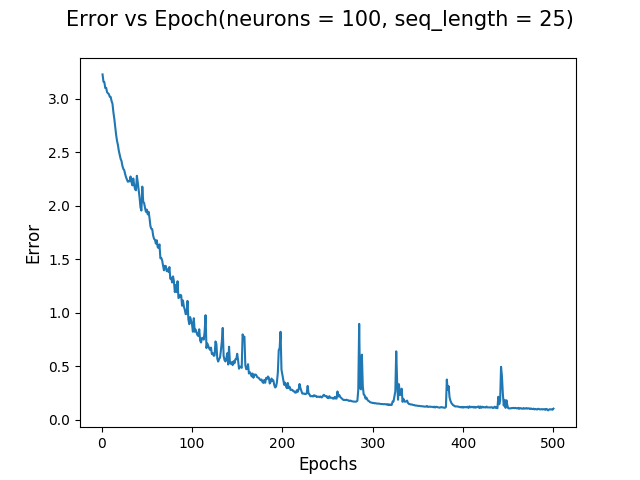

In [606]:
# Plotting Losses
epochs_arr = [i for i in range(1,501)]

train_loss_1 = np.array(train_loss_1).flatten()

fig1 = plt.figure()
plt.plot(epochs_arr,train_loss_1,label="Train Loss")
fig1.suptitle('Error vs Epoch(neurons = 100, seq_length = 25)', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.show()

In [607]:
train_loss_2 = train(200, 25, 500, 0.1)

iter 0, loss: 7.948891
W
-----
  @Ðe @÷c @.e @ce Uae @hef@ce \hc Ûkyu@cS @he Èce @ 
-----
iter 10, loss: 3.259400
iter 20, loss: 3.056814
iter 30, loss: 2.981129
iter 40, loss: 2.990297
iter 50, loss: 2.932304
iter 60, loss: 2.898758
iter 70, loss: 2.883944
iter 80, loss: 2.866418
iter 90, loss: 2.833905
iter 100, loss: 2.811927
W
-----
  ndarajese ogwe a ôurineee hyd do uitthWrr s,e   
-----
iter 110, loss: 2.798288
iter 120, loss: 2.789949
iter 130, loss: 2.785947
iter 140, loss: 2.782008
iter 150, loss: 2.754946
iter 160, loss: 2.761581
iter 170, loss: 2.748482
iter 180, loss: 2.732662
iter 190, loss: 2.723201
iter 200, loss: 2.712085
W
-----
  sereWi tws d.sfad e dftoroeamo. svn dor nlo toaf  
-----
iter 210, loss: 2.702272
iter 220, loss: 2.693691
iter 230, loss: 2.686342
iter 240, loss: 2.679369
iter 250, loss: 2.673179
iter 260, loss: 2.667584
iter 270, loss: 2.661936
iter 280, loss: 2.656912
iter 290, loss: 2.652019
iter 300, loss: 2.647342
W
-----
 iooo PiedaueP l ner f,  tmeA

<IPython.core.display.Javascript object>


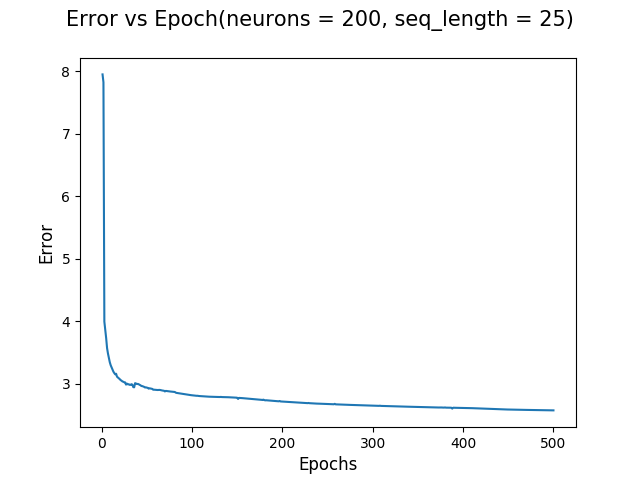

In [608]:
# Plotting Losses
epochs_arr = [i for i in range(1,501)]

train_loss_2 = np.array(train_loss_2).flatten()

fig2 = plt.figure()
plt.plot(epochs_arr,train_loss_2,label="Train Loss")
fig2.suptitle('Error vs Epoch(neurons = 200, seq_length = 25)', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.show()

In [609]:
train_loss_3 = train(50, 25, 500, 0.1)

iter 0, loss: 3.326525
W
-----
 i dy?Qfe   aai×.alaen ls    eeeohl a aa i.eytlasSi 
-----
iter 10, loss: 1.943546
iter 20, loss: 1.724372
iter 30, loss: 1.528289
iter 40, loss: 1.206857
iter 50, loss: 1.043297
iter 60, loss: 0.989792
iter 70, loss: 0.860829
iter 80, loss: 0.781611
iter 90, loss: 0.711111
iter 100, loss: 0.680578
W
-----
 e sead. Ane nithe skid. He we hee sion laed, the w 
-----
iter 110, loss: 0.640644
iter 120, loss: 0.586514
iter 130, loss: 0.584364
iter 140, loss: 0.575073
iter 150, loss: 0.491725
iter 160, loss: 0.585294
iter 170, loss: 0.544416
iter 180, loss: 0.578725
iter 190, loss: 0.512300
iter 200, loss: 0.519093
W
-----
 hted deed argo. dead. dte dead. Are witht doftle t 
-----
iter 210, loss: 0.459954
iter 220, loss: 0.411671
iter 230, loss: 0.535916
iter 240, loss: 0.408452
iter 250, loss: 0.405300
iter 260, loss: 0.383739
iter 270, loss: 0.460579
iter 280, loss: 0.524507
iter 290, loss: 0.379936
iter 300, loss: 0.434526
W
-----
 he qut rit thanghou hillre

<IPython.core.display.Javascript object>


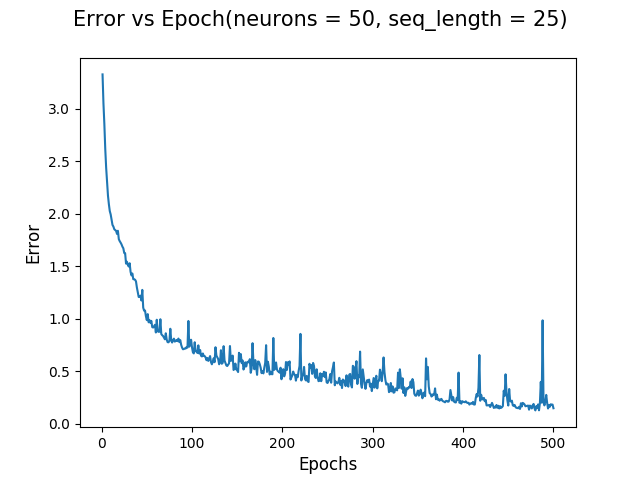

In [610]:
# Plotting Losses
epochs_arr = [i for i in range(1,501)]

train_loss_3 = np.array(train_loss_3).flatten()

fig3 = plt.figure()
plt.plot(epochs_arr,train_loss_3,label="Train Loss")
fig3.suptitle('Error vs Epoch(neurons = 50, seq_length = 25)', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.show()

In [611]:
train_loss_4 = train(100, 50, 500, 0.1)

iter 0, loss: 5.614401
W
-----
 atftd hWeyethd letdyeefdaweodoey neeele ddowc eec  
-----
iter 10, loss: 3.211825
iter 20, loss: 3.103560
iter 30, loss: 3.021954
iter 40, loss: 2.953076
iter 50, loss: 2.881768
iter 60, loss: 2.825983
iter 70, loss: 2.787564
iter 80, loss: 2.757909
iter 90, loss: 2.729786
iter 100, loss: 2.704033
W
-----
 a pog. yr. ale  lfimesklaysirgh ?heancedohemlsd. e 
-----
iter 110, loss: 2.687378
iter 120, loss: 2.671877
iter 130, loss: 2.560896
iter 140, loss: 2.535349
iter 150, loss: 2.523289
iter 160, loss: 2.511272
iter 170, loss: 2.494153
iter 180, loss: 2.464624
iter 190, loss: 2.405705
iter 200, loss: 2.383476
W
-----
 av hene rooagad tedmrlratma Slie itedr oi ,yae hed 
-----
iter 210, loss: 2.378293
iter 220, loss: 2.372146
iter 230, loss: 2.364024
iter 240, loss: 2.358475
iter 250, loss: 2.352426
iter 260, loss: 2.334192
iter 270, loss: 2.300388
iter 280, loss: 2.283710
iter 290, loss: 2.273825
iter 300, loss: 2.248303
W
-----
 iand soatnee.. qis e hihe 

<IPython.core.display.Javascript object>


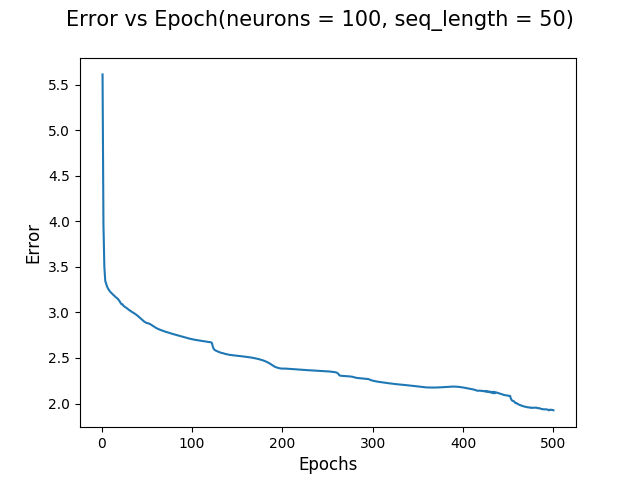

In [612]:
# Plotting Losses
epochs_arr = [i for i in range(1,501)]

train_loss_4 = np.array(train_loss_4).flatten()

fig4 = plt.figure()
plt.plot(epochs_arr,train_loss_4,label="Train Loss")
fig4.suptitle('Error vs Epoch(neurons = 100, seq_length = 50)', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.show()

In [613]:
train_loss_5 = train(100, 12, 500, 0.1)

iter 0, loss: 3.202491
W
-----
  id nth eitwtiiasssssniyatdiitlifhi niWoesrit ie   
-----
iter 10, loss: 2.706147
iter 20, loss: 2.435925
iter 30, loss: 2.389785
iter 40, loss: 2.286172
iter 50, loss: 2.073607
iter 60, loss: 2.006477
iter 70, loss: 2.110177
iter 80, loss: 2.006272
iter 90, loss: 1.907027
iter 100, loss: 1.796208
W
-----
 erkitty gilind ond bilngs. Gcout ingt woyssevertsi 
-----
iter 110, loss: 1.525361
iter 120, loss: 1.412337
iter 130, loss: 1.085980
iter 140, loss: 1.298770
iter 150, loss: 0.871960
iter 160, loss: 0.831322
iter 170, loss: 0.559519
iter 180, loss: 0.457813
iter 190, loss: 0.458540
iter 200, loss: 0.438751
W
-----
  hev the loog. He wim the safd. We hays, ngs he de 
-----
iter 210, loss: 0.320068
iter 220, loss: 0.311513
iter 230, loss: 0.362820
iter 240, loss: 0.240032
iter 250, loss: 0.284114
iter 260, loss: 0.208288
iter 270, loss: 0.192166
iter 280, loss: 0.526747
iter 290, loss: 0.141367
iter 300, loss: 0.160851
W
-----
 e saWed ihe bathint foinhi

<IPython.core.display.Javascript object>


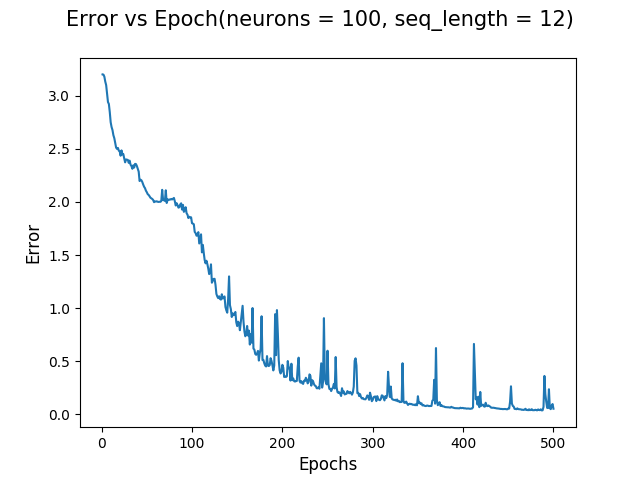

In [614]:
# Plotting Losses
epochs_arr = [i for i in range(1,501)]

train_loss_5 = np.array(train_loss_5).flatten()

fig5 = plt.figure()
plt.plot(epochs_arr,train_loss_5,label="Train Loss")
fig5.suptitle('Error vs Epoch(neurons = 100, seq_length = 12)', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.show()